# Load DB

In [2]:
import sqlite3
conn = sqlite3.connect('morphology.db')
c = conn.cursor()

# Get all the words

In [9]:
c.execute("""
CREATE TABLE words (word text)
""")

In [11]:
import pandas as pd
import requests
import itertools

letters = 'AĀBCČDEĒFGĢHIĪJKĶLĻMNŅOŌPQRSŠTUŪVZ'

for letter in letters:
    for page in itertools.count(1):
        print(letter, page)
        df = pd.read_html(requests.get(
            f"https://www.letonika.lv/groups/getEntryList.aspx?q={letter}&page={page}"
            "&pos=0&resID=10621033&sid=0.9246002265161375"
        ).text)
        c.executemany(
            "INSERT INTO words VALUES (?)",
            df[0].values
        )
        if "nākamie šķirkļi" not in df[0].values:
            break

A 1
A 2
A 3
A 4
A 5
A 6
A 7
A 8
A 9
A 10
A 11
A 12
A 13
A 14
A 15
A 16
A 17
A 18
A 19
A 20
A 21
A 22
A 23
A 24
A 25
A 26
A 27
A 28
A 29
Ā 1
Ā 2
B 1
B 2
B 3
B 4
B 5
B 6
B 7
B 8
B 9
B 10
B 11
B 12
C 1
C 2
C 3
C 4
C 5
Č 1
Č 2
D 1
D 2
D 3
D 4
D 5
D 6
D 7
D 8
D 9
D 10
D 11
D 12
D 13
D 14
D 15
D 16
D 17
E 1
E 2
E 3
E 4
E 5
E 6
E 7
Ē 1
F 1
F 2
F 3
F 4
F 5
F 6
G 1
G 2
G 3
G 4
G 5
G 6
G 7
G 8
Ģ 1
H 1
H 2
H 3
I 1
I 2
I 3
I 4
I 5
I 6
I 7
I 8
I 9
I 10
I 11
I 12
I 13
I 14
I 15
I 16
I 17
I 18
I 19
I 20
I 21
I 22
Ī 1
J 1
J 2
J 3
K 1
K 2
K 3
K 4
K 5
K 6
K 7
K 8
K 9
K 10
K 11
K 12
K 13
K 14
K 15
K 16
K 17
K 18
K 19
K 20
K 21
K 22
Ķ 1
L 1
L 2
L 3
L 4
L 5
L 6
L 7
L 8
L 9
L 10
L 11
Ļ 1
M 1
M 2
M 3
M 4
M 5
M 6
M 7
M 8
M 9
M 10
M 11
M 12
M 13
M 14
M 15
M 16
N 1
N 2
N 3
N 4
N 5
N 6
N 7
N 8
N 9
N 10
N 11
N 12
N 13
N 14
N 15
N 16
N 17
N 18
N 19
N 20
N 21
Ņ 1
O 1
O 2
O 3
Ō 1
P 1
P 2
P 3
P 4
P 5
P 6
P 7
P 8
P 9
P 10
P 11
P 12
P 13
P 14
P 15
P 16
P 17
P 18
P 19
P 20
P 21
P 22
P 23
P 24
P 25
P 26
P 27
P 28
P 29
P 

In [12]:
conn.commit()

# Webpage

In [113]:
c.execute("""
CREATE TABLE IF NOT EXISTS forms_html (word text, url text, html text)
""")

c.execute("""
CREATE INDEX IF NOT EXISTS forms_html_words ON forms_html (word)
""")

c.execute("""
CREATE INDEX IF NOT EXISTS words_words ON words (word)
""")

In [3]:
import lxml.html
from xml.etree import ElementTree
import requests
from multiprocessing import Pool
from datetime import datetime

def download(word):
    url = f"https://www.letonika.lv/groups/default.aspx?q={word}&title={word}/0&s=0&g=5&r=1100"
    tree = lxml.html.fromstring(requests.get(url).content)
    return word, url, ElementTree.tostring(tree.xpath("//td[@class='master_vidus']")[0])

pool = Pool(8)
while True:
    c.execute("""
    SELECT DISTINCT words.word FROM words
    LEFT JOIN forms_html
    ON words.word = forms_html.word
    WHERE INSTR(words.word, ' ') = 0 AND forms_html.word IS NULL
    LIMIT 500
    """)
    
    rows = c.fetchall()
    if len(rows) == 0:
        break

    c.executemany(
        "INSERT INTO forms_html VALUES (?, ?, ?)",
        pool.map(download, (row[0] for row in rows))
    )
    conn.commit()
    c.execute("SELECT COUNT(*) FROM forms_html")
    print("Processed", c.fetchall(), datetime.now())

In [4]:
from IPython.core.display import display, HTML
import lxml.html
from xml.etree import ElementTree
import pandas as pd
import numpy as np
import math

c.execute("""
CREATE TABLE IF NOT EXISTS forms
(word text, tags text, col_tags text, type text, form text)
""")

c.execute("""
SELECT forms_html.word, html
FROM forms_html
LEFT JOIN forms
ON forms.word = forms_html.word
WHERE forms.word IS NULL
""")

values = []
for row_index, row in enumerate(c):
    word, html = row
    try:
        tree = lxml.html.fromstring(html.decode("utf-8"))

        results = tree.xpath("//td[@class='Entrytext']")[0]

        entrytext = results.xpath("//span/span[@class='Entrytext']")[0].xpath("string()")
        tables = results.xpath("//span/table")

        print(row_index, word)
        for t in tables:
            df = pd.read_html(ElementTree.tostring(t))[0]
            cols = list(df)
            header_rows = max(
                i for i, ele in enumerate(t.xpath(".//tr")) if ele.attrib.get("bgcolor") == 'lightgrey')+1
            index = list(df[cols[0]])
            for col in cols[1:]:
                col = list(df[col])
                tags = zip(index[:header_rows], col[:header_rows])
                vals = zip(index[header_rows:], col[header_rows:])
                col_tags = " ; ".join(f"{k}: {v}" if str(k) != "nan" and k != v else v for k, v in tags)
                for val in vals:
                    values.append(
                        (word, entrytext, col_tags, val[0], val[1])
                    )
    except Exception as e:
        print("Fail", word, e)

c.executemany(
    "INSERT INTO forms VALUES (?, ?, ?, ?, ?)",
    values
)
conn.commit()
c.execute("SELECT COUNT(*) FROM forms")
print("Saved", c.fetchall())

0 A
1 A
2 A
3 A
Fail AAC list index out of range
Fail AAI list index out of range
Fail Abadāna list index out of range
Fail abdukcija list index out of range
Fail abduktors list index out of range
Fail Abo list index out of range
Fail abonentapakšlīnija list index out of range
11 abpus
Fail abreaģēt list index out of range
Fail abriss list index out of range
Fail abvērs list index out of range
Fail acetātfilma list index out of range
Fail acetātplēve list index out of range
Fail acetātšķiedras list index out of range
Fail acetildihidrokodeīns list index out of range
Fail acetilmetadols list index out of range
Fail aciditāte list index out of range
Fail acidometrs list index out of range
22 acīmredzot
Fail ACP list index out of range
Fail acusakta list index out of range
Fail acvadāma list index out of range
Fail adamantīns list index out of range
Fail adamsīts list index out of range
Fail adatturis list index out of range
Fail ADB list index out of range
Fail Adena list index out of ra

Fail apsardziba list index out of range
Fail aptiekmuzejs list index out of range
Fail apturis list index out of range
Fail aptvarste list index out of range
Fail apudšūnas list index out of range
Fail apvalde list index out of range
Fail apvedrežīms list index out of range
Fail apvērse list index out of range
Fail apzeme list index out of range
Fail apzīmētājkļūme list index out of range
252 apžēliņ!
253 ar
Fail arabiks list index out of range
Fail ARABOSAI list index out of range
Fail aramīds list index out of range
Fail Archie list index out of range
Fail Ardēni list index out of range
259 ardievu!
Fail areometrs list index out of range
Fail argilīts list index out of range
Fail arheoastronomija list index out of range
Fail arheobotānika list index out of range
Fail arheobotāniķis list index out of range
Fail arheogrāfija list index out of range
Fail arheometrija list index out of range
Fail arhīveksemplārs list index out of range
Fail arhīvfonds list index out of range
Fail arhīvis

Fail bagase list index out of range
Fail bagatele list index out of range
Fail bagātināt list index out of range
Fail baikas list index out of range
Fail baikeris list index out of range
500 bail
Fail Baireita list index out of range
Fail bakalaurante list index out of range
Fail bakalaurants list index out of range
Fail bakalaurantūra list index out of range
Fail bakara list index out of range
Fail baks list index out of range
Fail bakss list index out of range
Fail bakterofāgs list index out of range
Fail balādists list index out of range
Fail balbali list index out of range
Fail baletomāns list index out of range
Fail Balhašs list index out of range
Fail balka list index out of range
Fail balsa list index out of range
Fail balss/partija list index out of range
Fail balstieliktnis list index out of range
Fail balstkoks list index out of range
Fail balstplātne list index out of range
Fail balziens list index out of range
Fail baļļuks list index out of range
Fail bandrolēšana list inde

Fail čungurs list index out of range
816 d.
Fail dabasparks list index out of range
Fail dabassaimniecība list index out of range
Fail dacītporfirīts list index out of range
Fail daidžests list index out of range
Fail DAIS list index out of range
Fail dalenis list index out of range
Fail daļapeja list index out of range
Fail dammarsveķi list index out of range
Fail Dāmokls list index out of range
Fail dansings list index out of range
Fail dāņi list index out of range
Fail darbatteice list index out of range
Fail darbdrošība list index out of range
Fail darbgals list index out of range
Fail Dārbi list index out of range
Fail darbībа list index out of range
Fail darbnīcauto list index out of range
Fail darbnīcautomobilis list index out of range
Fail darbzemēšana list index out of range
Fail Darema list index out of range
Fail Dāresalāma list index out of range
Fail darījumdarbība list index out of range
Fail Dārvina list index out of range
Fail DAT list index out of range
Fail datnesis l

Fail dzirksteļkamera list index out of range
Fail dzirksteļsprauga list index out of range
Fail dzīvelīgs list index out of range
Fail dzīvesbiedrs/dzīvesbiedre list index out of range
Fail DZO list index out of range
Fail Džaipūra list index out of range
Fail džanaisms list index out of range
Fail džanduja list index out of range
Fail džaurs list index out of range
Fail džekfrūts list index out of range
Fail Džersisitija list index out of range
Fail džezotēka list index out of range
Fail džigers list index out of range
Fail džingo list index out of range
Fail džingoisms list index out of range
Fail džinsbikses list index out of range
Fail Džungārija list index out of range
Fail e list index out of range
Fail EAP list index out of range
Fail EBCDIC list index out of range
Fail ebulisms list index out of range
Fail eceššļūce list index out of range
Fail EDGE list index out of range
Fail edikts list index out of range
Fail EDMS list index out of range
Fail EDS list index out of range
110

Fail gaisspilvena list index out of range
Fail galamorēna list index out of range
Fail galaosta list index out of range
Fail galavalnītis list index out of range
Fail galazars list index out of range
Fail galdvitrīna list index out of range
Fail galenieks list index out of range
Fail galeona list index out of range
Fail Galindija list index out of range
Fail Galipole list index out of range
Fail galjarda list index out of range
Fail gallusskābe list index out of range
Fail galvanoklišeja list index out of range
Fail galvanomatrice list index out of range
Fail galvanostereotipija list index out of range
Fail galvasauts list index out of range
Fail galvasstacija list index out of range
1396 galvenokārt
Fail galviņkorķis list index out of range
Fail galvturis list index out of range
Fail gamelāns list index out of range
Fail gametofora list index out of range
1401 GAN
1402 gan
1403 gandrīz
1404 gar
1405 garāmejot
Fail garasfēra list index out of range
Fail garenadījums list index out of r

Fail hibrīdists list index out of range
Fail hidratants list index out of range
Fail hidrauloss list index out of range
Fail hidroakumulators list index out of range
Fail hidroaparāts list index out of range
Fail hidroaparatūra list index out of range
Fail hidroelektroietaise list index out of range
Fail hidrofilitāte list index out of range
Fail hidrofobitāte list index out of range
Fail hidrogāzdinamika list index out of range
Fail hidrogēls list index out of range
Fail hidroģeoloģija list index out of range
Fail hidrokodons list index out of range
Fail hidroksipetidīns list index out of range
Fail hidrolāze list index out of range
Fail hidrolīts list index out of range
Fail hidromorfinols list index out of range
Fail hidromorfons list index out of range
Fail hidromuskovīts… list index out of range
Fail hidrorezervuārs list index out of range
Fail hidrosilikāts list index out of range
Fail hidroslēgs list index out of range
Fail hidrosols list index out of range
Fail hidrotvertne lis

Fail Setikedasa list index out of range
Fail Severna list index out of range
Fail Sinsinati list index out of range
Fail Sirdarja list index out of range
Fail Sjerranevada list index out of range
Fail Skepaflovs list index out of range
Fail Skitija list index out of range
Fail Slavonija list index out of range
Fail Snoudons list index out of range
Fail Solforda list index out of range
Fail Solsberija list index out of range
Fail Solveifērts list index out of range
Fail Somersetšīra list index out of range
1947 St.
Fail Steforda list index out of range
Fail Stefordšīra list index out of range
Fail Sterlinga list index out of range
Fail Stiltona list index out of range
Fail Stoka list index out of range
Fail Stretmora list index out of range
Fail Stromboli list index out of range
Fail Sudeti list index out of range
Fail Sudetija list index out of range
Fail Sudāvija list index out of range
Fail Sukre list index out of range
Fail Surabaja list index out of range
Fail Svatini list index ou

Fail izbesīt list index out of range
2181 izceļot
Fail izcilgrebums list index out of range
Fail izcilspiedums list index out of range
Fail izcilņvārpsta list index out of range
Fail izciļņvārpsta list index out of range
2186 izdejot
Fail izdevējdarbs list index out of range
Fail izdevējinstitūcija list index out of range
Fail izdevējnumurs list index out of range
Fail izdevējorganizācija list index out of range
Fail izdevējprodukcija list index out of range
Fail izgrūdējsvira list index out of range
2193 izkarot
2194 izklaidu
2195 izklaidu-
Fail izklapatot list index out of range
Fail izkruķīties list index out of range
Fail izlīdzinātājaparāts list index out of range
Fail izlīdzinātājtvertne list index out of range
Fail izlīme list index out of range
Fail izmēriezīme list index out of range
Fail izmērzīme list index out of range
Fail izmēģinājumnodaļa list index out of range
Fail izodimorfisms list index out of range
Fail izogēns list index out of range
Fail izolāts list index out of

2434 klusītiņām
Fail klājaugs list index out of range
2436 klāt
2437 klātesot
Fail klātējs list index out of range
Fail klēpjauts list index out of range
Fail knauzerēties list index out of range
Fail kneipe list index out of range
Fail knielūgs list index out of range
Fail knope list index out of range
Fail knopka list index out of range
Fail knābjdzelis list index out of range
Fail kodaks list index out of range
Fail kodicils list index out of range
Fail kodol- list index out of range
Fail kodolcirvis list index out of range
Fail kodētājs-dekodētājs list index out of range
Fail kognāts list index out of range
Fail koira list index out of range
Fail koknejs list index out of range
Fail kokote list index out of range
Fail kokķieģeļu list index out of range
Fail kolika list index out of range
Fail kolimatorteleskops list index out of range
Fail kollers list index out of range
Fail kolts list index out of range
Fail kolumna list index out of range
Fail kolumncipars list index out of rang

Fail laps list index out of range
Fail lasts list index out of range
Fail lasāmbrilles list index out of range
Fail lasēns list index out of range
Fail lasītkārs list index out of range
Fail lasītnespēja list index out of range
Fail lasītība list index out of range
Fail laternzivs list index out of range
Fail laterīts list index out of range
Fail latinizācija list index out of range
Fail laudas list index out of range
Fail laulātais/laulātā list index out of range
Fail laurulapa list index out of range
Fail lazdurieksts list index out of range
Fail lazēt list index out of range
Fail laškrāsa list index out of range
Fail lecmīna list index out of range
Fail leduspiesis list index out of range
Fail leikociti list index out of range
Fail lejamforma list index out of range
Fail lejamkauss list index out of range
Fail lejamrīki list index out of range
Fail lejasģērbs list index out of range
2741 lejup
Fail lejupbultiņa list index out of range
2743 lejāk
Fail lekties list index out of range


Fail meteorīds list index out of range
Fail metilāze list index out of range
Fail metilēt list index out of range
Fail metālšķiedras list index out of range
Fail metšāviens list index out of range
Fail mezenhīma list index out of range
Fail meziāls list index out of range
Fail mežsaudze list index out of range
Fail miasmi list index out of range
Fail midi list index out of range
Fail midlietotne list index out of range
Fail miecmizas list index out of range
Fail mieloma list index out of range
Fail mietne list index out of range
Fail mijdarbīgs list index out of range
Fail mijdarbīgums list index out of range
Fail mijieskaits list index out of range
Fail mikro list index out of range
Fail mikro- list index out of range
Fail mikroasamblers list index out of range
Fail mikrobiāls list index out of range
Fail mikrobuss list index out of range
Fail mikrocefāls list index out of range
Fail mikrofilaments list index out of range
Fail mikrofiša list index out of range
Fail mikrofāze list inde

Fail nesējorganisms list index out of range
Fail nevalstnieks list index out of range
Fail nevaronis list index out of range
3237 nevietā
3238 nevilcinoties
3239 nevis
3240 neviļus
3241 nez
3242 nezin
3243 nezinot
Fail nezināšana list index out of range
3245 nešus
3246 nešķirot
Fail nežīds list index out of range
Fail nieršūna list index out of range
Fail nihonijs list index out of range
Fail niks list index out of range
Fail niktalopija list index out of range
Fail nitrometrs list index out of range
Fail nitrons list index out of range
Fail nitrooksīds list index out of range
Fail nizāms list index out of range
Fail niķupolis list index out of range
3257 no
3258 nobarot
Fail nobarotava list index out of range
Fail nobarotavsārņošana list index out of range
3261 nobaroties
Fail nociceptors list index out of range
3263 nodejot
Fail nodeva[s] list index out of range
Fail nodokļsvars list index out of range
Fail nogriezējgrupa list index out of range
Fail nogulsnas list index out of range

Fail pampers list index out of range
3482 pamīšus
Fail panafrikānisms list index out of range
Fail panafrikāņu list index out of range
Fail panamerikāņu list index out of range
Fail panatella list index out of range
Fail pandits list index out of range
Fail panegirists list index out of range
Fail panenteisms list index out of range
Fail panga list index out of range
Fail pangains list index out of range
Fail pangābols list index out of range
Fail panini list index out of range
Fail panoramēšanа list index out of range
Fail paotējums list index out of range
Fail paotēt list index out of range
Fail paotēšana list index out of range
Fail papaja list index out of range
Fail papild- list index out of range
Fail papildakreditīvs list index out of range
Fail papildapraksts list index out of range
Fail papildasignējumi list index out of range
Fail papildaugstumlīkne list index out of range
Fail papilddaudzums list index out of range
Fail papildieraksts list index out of range
Fail papildiespi

Fail piekarzīmogs list index out of range
3727 piektkārt
Fail piekļūstamība list index out of range
3729 piemērot
3730 piemēroties
Fail piespiedējcilindrs list index out of range
Fail piespiedējpierīce list index out of range
Fail piespiedējveltnītis list index out of range
Fail piespraudjosla list index out of range
Fail piestala list index out of range
Fail piesūcējierīce list index out of range
Fail piesūcējveltnis list index out of range
Fail piesūcējveltnītis list index out of range
Fail pietsegs list index out of range
Fail pievadlīnija list index out of range
Fail pievedbāka list index out of range
Fail piezīmе list index out of range
Fail pieļurbāties list index out of range
Fail piešprice list index out of range
Fail pigmentkrāsa list index out of range
Fail piknisks list index out of range
Fail pikniķis list index out of range
Fail pikrīts list index out of range
Fail pikša list index out of range
Fail pikšķerēšana list index out of range
Fail pildenis list index out of range

Fail priekšmetotājs list index out of range
Fail priekšmetošana list index out of range
Fail priekšmuitojums list index out of range
Fail priekšpirmveide list index out of range
Fail priekšrakstne list index out of range
Fail priekštituls list index out of range
Fail priekšvalnis list index out of range
Fail prieve list index out of range
Fail prima list index out of range
Fail primitāte list index out of range
Fail principatteice list index out of range
Fail prinelis list index out of range
Fail prioritēt list index out of range
Fail privātmuzejs list index out of range
Fail prizmoīds list index out of range
Fail priāpisms list index out of range
Fail proaktīvs list index out of range
Fail probabilisms list index out of range
Fail probands list index out of range
Fail problēmseminārs list index out of range
Fail procentriola list index out of range
Fail procentīle list index out of range
Fail profesionalizēties list index out of range
Fail profesionālapskate list index out of range
Fa

Fail raudze list index out of range
4227 raug!
Fail rauknis list index out of range
Fail raškete list index out of range
Fail ražojumatbildība list index out of range
4231 re
4232 re!
Fail reaktance list index out of range
Fail reaktoplasts list index out of range
Fail rebes list index out of range
Fail rece list index out of range
Fail receptivitāte list index out of range
Fail recsija list index out of range
Fail recto list index out of range
Fail redeponēšana list index out of range
Fail redingots list index out of range
Fail reduplikācja list index out of range
4243 redz!
Fail reflukss list index out of range
Fail refraktors list index out of range
Fail refraktārs list index out of range
Fail refraktīvs list index out of range
Fail refūgija list index out of range
Fail reglete list index out of range
Fail regmaglipti list index out of range
Fail regolīts list index out of range
Fail regulētājslodze list index out of range
Fail regulētājūdenskrātuve list index out of range
Fail regā

Fail sasafrass list index out of range
Fail saskardvīnis list index out of range
Fail sasmalcināmība list index out of range
Fail saspiedējskrūve list index out of range
4487 sastāv-
4488 sastāv...
Fail satelītapakšstacija list index out of range
Fail satelītzobrats list index out of range
Fail satirs list index out of range
Fail saturnisms list index out of range
Fail satvarcilpa list index out of range
Fail satvērējmehānisms list index out of range
Fail satīstība list index out of range
Fail saudze list index out of range
Fail saulīšsakta list index out of range
Fail sausmasa list index out of range
Fail sausnejs list index out of range
4500 savairot
4501 savairoties
Fail savienojumvieta list index out of range
Fail savienotājgabals list index out of range
Fail savienotājskrūve list index out of range
Fail savienotājtiltiņš list index out of range
Fail savienotājuzmava list index out of range
Fail savilcējskrūve list index out of range
4508 savlaikus
4509 savrup
Fail savrupkaps list 

Fail spodrpulējums list index out of range
Fail spodrpulēšana list index out of range
Fail spoguļgaldiņš list index out of range
Fail spoguļplakne list index out of range
Fail spoguļteleskops list index out of range
Fail spoileris list index out of range
Fail spoilers list index out of range
Fail sportauto list index out of range
Fail spraidi list index out of range
Fail spraudeklis list index out of range
Fail spraudkartotēka list index out of range
Fail spraudligzda list index out of range
Fail spraudne list index out of range
Fail sprauds list index out of range
Fail spraugnolasītājs list index out of range
Fail sprauklis list index out of range
Fail spreijas list index out of range
Fail spriegojumpierīce list index out of range
Fail spriegotājveltnis list index out of range
Fail spriegotājveltnītis list index out of range
Fail spriegummainis list index out of range
Fail sprost- list index out of range
Fail sprostceļš list index out of range
Fail sprostgredzens list index out of ran

Fail tans list index out of range
Fail tanscendents list index out of range
Fail tantalīts list index out of range
Fail tanžīrs list index out of range
Fail tapascirvis list index out of range
Fail tapioka list index out of range
Fail tapnis list index out of range
Fail taranēt list index out of range
Fail tarlatans list index out of range
Fail tartrazīns list index out of range
Fail tartāns list index out of range
Fail tasnieks list index out of range
Fail tauklodīte list index out of range
Fail tauksvītras list index out of range
Fail taukvāre list index out of range
Fail taustcirkulis list index out of range
Fail taustiņslēgs list index out of range
5044 taustoties
Fail tautasmelodija list index out of range
Fail tautasmūzika list index out of range
5047 tavuprāt
5048 taču
5049 te
5050 teciņiem
5051 teciņus
Fail tedeska list index out of range
Fail tedijas list index out of range
Fail tehnofobija list index out of range
Fail tehnogrāfija list index out of range
Fail tehnogēns list i

Fail tupu list index out of range
5284 tur
Fail turas list index out of range
Fail turboagregāts list index out of range
Fail turbīnrats list index out of range
Fail turgors list index out of range
5289 turklāt
5290 turp
5291 turpat
Fail turpinājumapdrošināšana list index out of range
Fail turpinājumresurss list index out of range
Fail turpināmizglītība list index out of range
5295 turpmāk
5296 turpretī
5297 turpu
Fail turētājlīste list index out of range
Fail turētājsliede list index out of range
Fail tusnis list index out of range
Fail tusteps list index out of range
Fail tusēt list index out of range
Fail tusētājs list index out of range
Fail tuvjūras list index out of range
Fail tuvrindsēja list index out of range
Fail tuvskaņas list index out of range
Fail tvaikcaurlaidība list index out of range
Fail tvips list index out of range
Fail tvītot list index out of range
5310 tādējādi
5311 tādēļ
5312 tālab
Fail tālbraucējkapteinis list index out of range
Fail tālerratiņi list index out

Fail violončells list index out of range
Fail virpuļcaurule list index out of range
5591 virs
Fail virsgriezums list index out of range
Fail virsieraksts list index out of range
Fail virsizmaksas list index out of range
Fail virsizmērs list index out of range
Fail virskalandrs list index out of range
Fail virsklājs list index out of range
Fail virskrava list index out of range
Fail virslaide list index out of range
Fail virsmaksa list index out of range
5601 virspus
Fail virspārdots list index out of range
Fail virssalikums list index out of range
Fail virstituls list index out of range
Fail virsvainags list index out of range
Fail virsģērbi list index out of range
Fail virsģērbs list index out of range
Fail virtualitāte list index out of range
Fail virulents list index out of range
Fail virzienstūre list index out of range
Fail virzuļgredzens list index out of range
5612 vis
5613 visapkārt
5614 visbeidzot
5615 viscaur
5616 visgarām
Fail visgudr(el)is list index out of range
Fail visgu

5873 šantažēt
5874 šantažētājs
5875 šantāža
5876 šantāžists
5877 šariats
5878 šarlaks
5879 šarlatāns
5880 šarmants
5881 šarms
Fail šarmēt list index out of range
Fail šarnīr- list index out of range
5884 šarnīra
5885 šarnīrs
5886 šarnīrsavienojums
Fail šarnīruzgrieznis list index out of range
5888 šarnīrveida
Fail šarnīrvira list index out of range
5890 šarpija
5891 šarāde
5892 šaržs
5893 šasija
5894 šatens
5895 šaubas
5896 šaubīgs
5897 šaubīties
5898 šaubīšanās
5899 šaudīgs
5900 šaudīt
5901 šaudīties
5902 šaudīšanās
5903 šaujamais
5904 šaujamierocis
5905 šaujamieroči
5906 šaujamloks
5907 šaujamlūka
5908 šaujampulveris
5909 šaujlauks
5910 šaura
5911 šaurapraide
5912 šauri
Fail šaurierīce list index out of range
5914 šaurjoslas
5915 šaurleņķa
5916 šaurleņķis
5917 šaurs
Fail šaursaslēdze list index out of range
Fail šaursaslēgs list index out of range
Fail šaursliedes list index out of range
5921 šaursliežu
5922 šaurums
5923 šaurība
5924 šausmas
5925 šausminošs
5926 šausmināt
5927 šausmi

Fail šķērstrieciens list index out of range
6367 šķērstroksnis
Fail šķērsvalnītis list index out of range
Fail šķērsvalnīši list index out of range
6370 šķērsvirziens
6371 šķērszarna
6372 šķērszāģis
6373 šķērsām
Fail šķērsēvelmašīna list index out of range
6375 šķērsķieģelis
Fail šķērsšķiedra list index out of range
6377 šķērētājs
Fail šķērīte list index out of range
Fail šķēršošana list index out of range
6380 šķībacainais
6381 šķībacains
6382 šķībi
6383 šķībs
6384 šķībums
6385 šķīdinošs
6386 šķīdinājums
6387 šķīdināt
6388 šķīdinātājs
6389 šķīdināšana
6390 šķīdonis
6391 šķīdoņa
6392 šķīdums
6393 šķīdība
6394 šķīrējtiesa
6395 šķīrējtiesas
6396 šķīrējtiesnesis
6397 šķīst
6398 šķīstamība
6399 šķīstošs
6400 šķīsts
6401 šķīstums
6402 šķīstība
6403 šķīstījošs
6404 šķīstīt
6405 šķīstītava
6406 šķīstītavas
6407 šķīstītavas-
6408 šķīstīties
6409 šķīstīšana
6410 šķīstīšanas-
6411 šķīstīšanās
6412 šķīvis
6413 šķīvji
6414 šķīvjveida
6415 šķīvītis
6416 šķīšana
6417 šķūnis
6418 šķūre
6419 šķūrēt
64

# Cleanup

In [10]:
c.execute("DROP TABLE IF EXISTS lex")

In [11]:
c.execute("""
CREATE TABLE lex AS
SELECT DISTINCT
    CASE
        WHEN INSTR(form, ';') THEN SUBSTR(form, 1, INSTR(form, ';')-1)
        ELSE form
    END AS word,
    CASE
        WHEN INSTR(tags, 'lietvārds') THEN 'lietvārds'
        WHEN INSTR(tags, 'īpašības vārds') THEN 'īpašības vārds'
        WHEN INSTR(tags, 'nenoteiktais vietniekvārds') THEN 'nenoteiktais vietniekvārds'
        WHEN INSTR(tags, 'darbības vārds') THEN 'darbības vārds'
        WHEN INSTR(tags, 'apstākļa vārds') THEN 'apstākļa vārds'
        WHEN INSTR(tags, 'pamata skaitļa vārds') THEN 'pamata skaitļa vārds'
        WHEN INSTR(tags, 'kārtas skaitļa vārds') THEN 'kārtas skaitļa vārds'
        WHEN INSTR(tags, 'saiklis') THEN 'saiklis'
        WHEN INSTR(tags, 'izsauksmes vārds') THEN 'izsauksmes vārds'
        WHEN INSTR(tags, 'personas vietniekvārds') THEN 'personas vietniekvārds'
        WHEN INSTR(tags, 'izsauksmes vārds') THEN 'izsauksmes vārds'
        WHEN INSTR(tags, 'saīsinājums') THEN 'saīsinājums'
        WHEN INSTR(tags, 'prievārds') THEN 'prievārds'
        
        WHEN INSTR(tags, 'vispārināmais vietniekvārds') THEN 'vispārināmais vietniekvārds'
        WHEN INSTR(tags, 'norādāmais vietniekvārds') THEN 'norādāmais vietniekvārds'
        WHEN INSTR(tags, 'noliedzamais vietniekvārds') THEN 'noliedzamais vietniekvārds'
        WHEN INSTR(tags, 'jautājamais vietniekvārds') THEN 'jautājamais vietniekvārds'
        WHEN INSTR(tags, 'noteicamais vietniekvārds') THEN 'noteicamais vietniekvārds'
        WHEN INSTR(tags, 'attieksmes vietniekvārds') THEN 'attieksmes vietniekvārds'
        WHEN INSTR(tags, 'piederības vietniekvārds') THEN 'piederības vietniekvārds'
        
        WHEN INSTR(tags, 'lokāms ciešamās kārtas Tagadnes divdabis') THEN 'lokāms ciešamās kārtas Tagadnes divdabis'
        WHEN INSTR(tags, 'lokāms darāmās kārtas Tagadnes divdabis') THEN 'lokāms darāmās kārtas Tagadnes divdabis'
        WHEN INSTR(tags, 'lokāms ciešamās kārtas Pagātnes divdabis') THEN 'lokāms ciešamās kārtas Pagātnes divdabis'
        WHEN INSTR(tags, 'lokāms darāmās kārtas Pagātnes divdabis') THEN 'lokāms darāmās kārtas Pagātnes divdabis'

        ELSE ''
    END AS type,
    CASE
        WHEN INSTR(col_tags, 'Vienskaitlis') THEN 'vienskaitlis'
        WHEN INSTR(col_tags, 'Daudzskaitlis') THEN 'daudzskaitlis'

        WHEN type = 'Es' OR type = 'Tu' OR type = 'Viņš; viņa' THEN 'vienskaitlis'
        WHEN type = 'Mēs' OR type = 'Jūs' OR type = 'Viņi; viņas' THEN 'daudzskaitlis'
        ELSE ''
    END AS value,
    CASE
        WHEN INSTR(col_tags, 'Vīriešu dzimte') THEN 'vīriešu dzimte'
        WHEN INSTR(col_tags, 'Sieviešu dzimte') THEN 'sieviešu dzimte'
        ELSE ''
    END AS gender,
    CASE
        WHEN INSTR(col_tags, 'Tagadne') THEN 'tagadne'
        WHEN INSTR(col_tags, 'Pagātne') THEN 'pagātne'
        WHEN INSTR(col_tags, 'Nākotne') THEN 'nākotne'
        
        WHEN form = word  AND type = 'darbības vārds' THEN 'infinitive'
        ELSE ''
    END AS tense,
    CASE
        WHEN type = 'Es' OR type = 'Mēs' THEN '1. persona'
        WHEN type = 'Tu' OR type = 'Jūs' THEN '2. persona'
        WHEN type = 'Viņš; viņa' OR type = 'Viņi; viņas' THEN '3. persona'
        ELSE ''
    END AS person,
    CASE
        WHEN INSTR(tags, 'nenoteiksme') THEN 'nenoteiksme'
        WHEN INSTR(tags, 'pavēles izteiksme') THEN 'pavēles izteiksme'
        WHEN INSTR(tags, 'īstenības izteiksme') THEN 'īstenības izteiksme'
        WHEN INSTR(tags, 'vajadzības izteiksme') THEN 'vajadzības izteiksme'
        ELSE ''
    END AS mood,
    CASE
        WHEN INSTR(col_tags, 'Pārākā pakāpe') THEN 'pārākā pakāpe'
        WHEN INSTR(col_tags, 'Pamata pakāpe') THEN 'pamata pakāpe'
        WHEN INSTR(col_tags, 'Vispārākā pakāpe') THEN 'vispārākā pakāpe'
        ELSE ''
    END AS degree,
    CASE
        WHEN type = 'Nominatīvs' THEN 'nominatīvs'
        WHEN type = 'Akuzatīvs' THEN 'akuzatīvs'
        WHEN type = 'Ģenitīvs' THEN 'ģenitīvs'
        WHEN type = 'Datīvs' THEN 'datīvs'
        WHEN type = 'Lokatīvs' THEN 'lokatīvs'
        WHEN type = 'Vokatīvs' THEN 'vokatīvs'
        ELSE ''
    END AS nouncase,
    CASE
        WHEN INSTR(col_tags, 'noteiktā galotne') THEN 'noteiktā galotne'
        WHEN INSTR(col_tags, 'nenoteiktā galotne') THEN 'nenoteiktā galotne'
        ELSE ''
    END AS definite
FROM forms
""")
conn.commit()

# Model

In [1]:
import sqlite3
conn = sqlite3.connect('morphology.db')
c = conn.cursor()

In [2]:
from sklearn import tree
from sklearn import preprocessing
import numpy as np

word_length = 7

c.execute("PRAGMA table_info(lex)")
c.fetchone() # Skip word column
columns = [col[1] for col in c]

# Prepend because suffix matters, so keep that in the same place
c.execute(f"""
SELECT
    SUBSTR('{' '*word_length}' || word, LENGTH(word), LENGTH(word)+{word_length}),
    {', '.join(columns)} 
FROM lex WHERE word != '-'
""")

X_raw, Y_raw = zip(*[(row[0], row[1:]) for row in c])


transformers = [preprocessing.LabelEncoder() for i in range(len(Y_raw[0]))]
Y_raw = np.array(Y_raw)
Y = np.vstack([t.fit_transform(Y_raw[:, i]) for i, t in enumerate(transformers)]).T
X = np.array([[ord(c) for c in s] for s in X_raw])
print(X, Y)

[[ 32  32  32 ...  97 107 115]
 [ 32  32  32 ...  97 107  97]
 [ 32  32  97 ... 107  97 109]
 ...
 [ 32  32 363 ... 326  97 115]
 [ 32  32 363 ... 326 257 115]
 [ 32  32 363 ... 326  97 115]] [[7 2 0 ... 0 4 0]
 [7 2 0 ... 0 6 0]
 [7 2 0 ... 0 2 0]
 ...
 [7 1 0 ... 0 1 0]
 [7 1 0 ... 0 3 0]
 [7 1 0 ... 0 5 0]]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.80, random_state=42)

In [4]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()
clf.fit(X_train, Y_train)
Y_pred_test = clf.predict(X_test)

print("Baseline")
for i, col in enumerate(columns):
    accr = np.sum(Y_test[:, i] == Y_pred_test[:, i]) / Y_test.shape[0]
    print(col, accr)

/home/aidan/.local/lib/python3.9/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


Baseline
type 0.2602127974859086
value 0.4961269515522949
gender 0.4289291066475798
tense 0.7261095609286928
person 0.6783503511675762
mood 0.6637018262950702
degree 0.4094555225015657
nouncase 0.1500842969938266
definite 0.5371969222510513


In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0, max_depth=20)
path = clf.cost_complexity_pruning_path(X_train, Y_train)
all_ccp_alphas, impurities = path.ccp_alphas, path.impurities

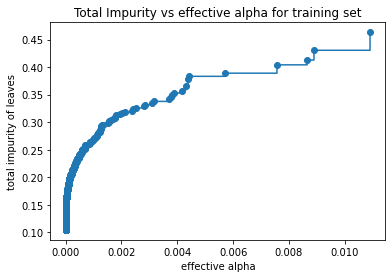

In [6]:
import matplotlib.pyplot as plt
plt.plot(all_ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

In [7]:
ccp_alphas = [
    alpha
    for alpha in all_ccp_alphas[:-1]
    if alpha > 0.0005 and alpha < 0.0007
]
node_counts, depth, test_scores = [], [], []
len(ccp_alphas)

22

In [8]:
assert len(node_counts) == len(test_scores)
for ccp_alpha in ccp_alphas[len(node_counts):]:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, Y_train)
    node_counts.append(clf.tree_.node_count)
    depth.append(clf.tree_.max_depth)
    test_scores.append(np.sum(clf.predict(X_test) == Y_test) / Y_test.size)
    print(node_counts[-1], depth[-1], test_scores[-1])
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

211 12 0.8177984240951159
211 12 0.8177984240951159
207 12 0.8172168726949192
205 12 0.8168365498841867
203 12 0.8164621295716402
201 12 0.8162089434652511


KeyboardInterrupt: 

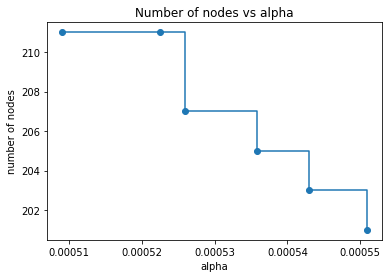

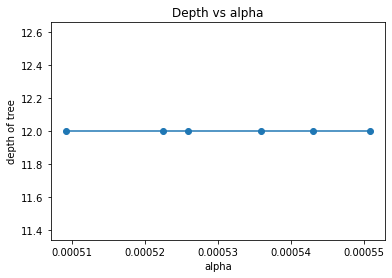

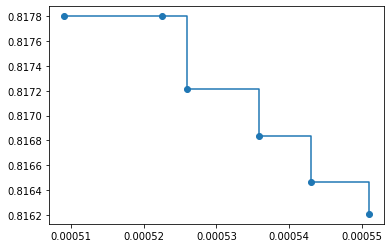

In [9]:
plt.plot(ccp_alphas[:len(node_counts)], node_counts, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("number of nodes")
plt.title("Number of nodes vs alpha")
plt.show()

plt.plot(ccp_alphas[:len(depth)], depth, marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("depth of tree")
plt.title("Depth vs alpha")
plt.show()

plt.plot(ccp_alphas[:len(test_scores)], test_scores, marker='o', label="test", drawstyle="steps-post")
plt.show()

In [12]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0003)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0003, random_state=0)

In [13]:
Y_pred_test = clf.predict(X_test)

for i, col in enumerate(columns):
    accr = np.sum(Y_test[:, i] == Y_pred_test[:, i]) / Y_test.shape[0]
    print(col, accr)

type 0.7467399570546658
value 0.8037026371119262
gender 0.8544625682204527
tense 0.9376258164086965
person 0.8728184832692135
mood 0.9277429375055919
degree 0.8064503276818467
nouncase 0.6754600686678
definite 0.8748035866064239


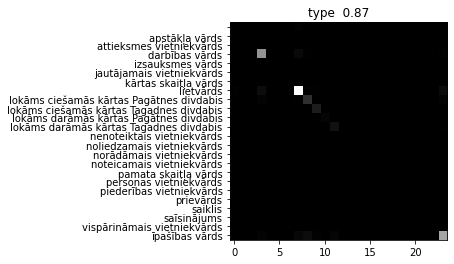

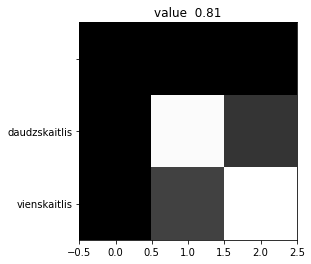

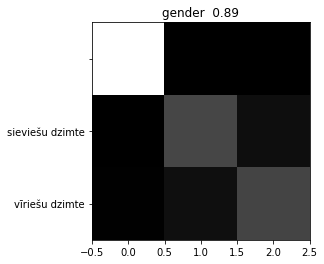

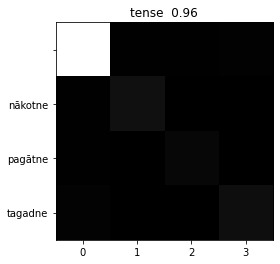

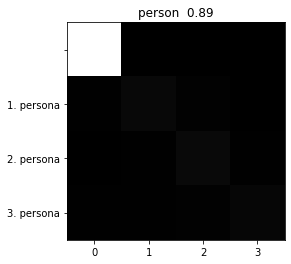

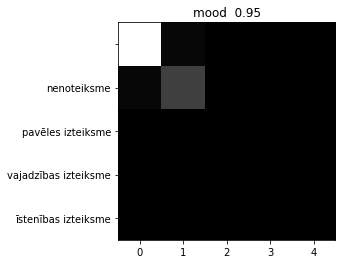

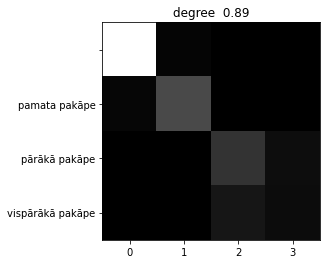

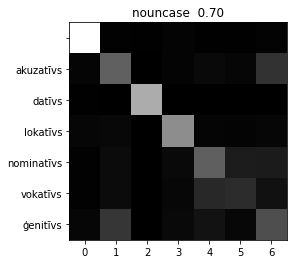

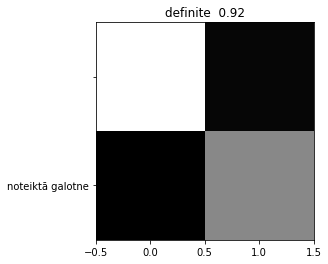

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

for i, (col, t) in enumerate(zip(columns, transformers)):
    accr = np.sum(Y_test[:, i] == Y_pred_test[:, i]) / Y_test.shape[0]
    cm = confusion_matrix(Y_test[:, i], Y_pred_test[:, i])
    plt.imshow(cm , cmap='gray', interpolation='nearest')
    plt.yticks(np.arange(len(t.classes_)), t.classes_)
    plt.title(f"{col}  {accr:.2f}")
    plt.show()

In [9]:
def predict(s, clf):
    tree_ = clf.tree_
    classes_ = clf.classes_
    feature, threshold, left, right, value = \
        tree_.feature, tree_.threshold, tree_.children_left, tree_.children_right, tree_.value
    def _helper(node):
        if left[node] >= 0:
            if s[feature[node]] <= threshold[node]:
                return _helper(left[node])
            else:
                return _helper(right[node])
        else:
            return np.argmax(value[node], axis=1)
    maxes = _helper(0)
    return np.array([classes_[i][v] for i, v in enumerate(maxes)])

In [15]:
f = open("morphlex.go", "w")

classes = ',\n'.join(
    '{%s}' % ', '.join(
        '"'+transformers[i].classes_[clf.classes_[i][v]]+'"' for i, v in enumerate(np.argmax(value, axis=1))
    )
    for value in clf.tree_.value
) + ','
feature = ', '.join(str(x) for x in clf.tree_.feature)
threshold = ', '.join(str(x) for x in clf.tree_.threshold)
left = ', '.join(str(x) for x in clf.tree_.children_left)
right = ', '.join(str(x) for x in clf.tree_.children_right)

f.write("""package main

import (
    "bufio"
    "os"
    "fmt"
    "log"
)

func predict(s string) []string {
    classes := [][]string{
        %s
    }
    feature := []int{%s}
    threshold := []float32{%s}
    left := []int{%s}
    right := []int{%s}
    
    var helper func(node int) []string
    helper = func(node int) []string {
        if left[node] >= 0 {
            if float32(int(s[feature[node]])) <= threshold[node] {
                return helper(left[node])
            } else {
                return helper(right[node])
            }
        } else {
            return classes[node]
        }
    }
    return helper(0)
}

func main() {
    scanner := bufio.NewScanner(os.Stdin)
    for scanner.Scan() {
        fmt.Println(predict(fmt.Sprintf("%%9v", scanner.Text())))
    }

    if err := scanner.Err(); err != nil {
        log.Println(err)
    }
}
""" % (classes, feature, threshold, left, right))
f.close()

In [16]:
%%bash

gofmt -w morphlex.go
go build morphlex.go

In [17]:
%%bash
echo "patīk" | ./morphlex

[lietvārds vienskaitlis      lokatīvs ]


In [13]:
vals = predict([ord(c) for c in "%9s" % "patīk"], clf)

[t.inverse_transform([v])[0] for t, v in zip(transformers, vals)]

['lietvārds', 'vienskaitlis', '', '', '', '', '', 'lokatīvs', '']

In [14]:
Y_pred_raw = np.vstack([predict(x, clf) for x in X])
for i, col in enumerate(columns):
    num_accr = np.sum(Y_test[:, i] == Y_pred_test[:, i]) / Y_test.shape[0]
    accr = np.sum(Y_pred[:, i] == Y_pred_raw[:, i]) / Y_raw.shape[0]
    print(col, accr, num_accr)

NameError: name 'Y_pred' is not defined